Code adopted from - https://github.com/uoip/monoVO-python

The data for this tutorial can be downloaded from here - https://drive.google.com/drive/folders/1Y-78vFnFBnc9JkjjX_i72aoeCpof7HjP?usp=sharing

## Visual Odometry

Visual odometry is a technique used in robotics and computer vision to estimate the motion of a camera or a vehicle using only visual inputs, typically from one or more cameras. It involves analyzing consecutive images captured by the camera(s) to track the camera's movement and estimate its trajectory over time.

Here's how visual odometry typically works:-


1.   Feature Detection and Tracking - The process begins by detecting and tracking distinctive visual features (such as corners, edges, or keypoints) in successive image frames
2.   Motion Estimation - Using the tracked features, visual odometry algorithms compute the relative motion between consecutive frames. This motion estimation can be done using various techniques, such as feature matching, optical flow estimation, or direct image alignment methods.
3.   Pose Estimation - The relative motion estimates are integrated over time to estimate the camera's trajectory or pose (position and orientation) as it moves through the environment. This involves accumulating motion estimates and updating the camera's pose accordingly.
4.   Loop Closure and Optimization - To improve accuracy and robustness, visual odometry systems often incorporate loop closure detection and optimization techniques.



Could you name a few optimization techniques? We saw a couple of them in the previous tutorials.




In [ ]:
import numpy as np
import cv2
from os import listdir
from tqdm import tqdm
import matplotlib.pyplot as plt

In [ ]:
STAGE_FIRST_FRAME = 0
STAGE_SECOND_FRAME = 1
STAGE_DEFAULT_FRAME = 2
kMinNumFeature = 1500

In [ ]:
lk_params = dict(winSize  = (21, 21),
             	criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 30, 0.01))

In [ ]:
def featureTracking(image_ref, image_cur, px_ref):
	kp2, st, err = cv2.calcOpticalFlowPyrLK(image_ref, image_cur, px_ref, None, **lk_params)  #shape: [k,2] [k,1] [k,1]

	st = st.reshape(st.shape[0])
	kp1 = px_ref[st == 1]
	kp2 = kp2[st == 1]

	return kp1, kp2

In [ ]:
class PinholeCamera:
	def __init__(self, width, height, fx, fy, cx, cy,
				k1=0.0, k2=0.0, p1=0.0, p2=0.0, k3=0.0):
		self.width = width
		self.height = height
		self.fx = fx
		self.fy = fy
		self.cx = cx
		self.cy = cy
		self.distortion = (abs(k1) > 0.0000001)
		self.d = [k1, k2, p1, p2, k3]

In [ ]:
class VisualOdometry:
	def __init__(self, cam, annotations):
		self.frame_stage = 0
		self.cam = cam
		self.new_frame = None
		self.last_frame = None
		self.cur_R = None
		self.cur_t = None
		self.px_ref = None
		self.px_cur = None
		self.focal = cam.fx
		self.pp = (cam.cx, cam.cy)
		self.trueX, self.trueY, self.trueZ = 0, 0, 0
		self.detector = cv2.FastFeatureDetector_create(threshold=25, nonmaxSuppression=True)
		with open(annotations) as f:
			self.annotations = f.readlines()

	def getAbsoluteScale(self, frame_id):  # specialized for KITTI odometry dataset
		ss = self.annotations[frame_id-1].strip().split()
		x_prev = float(ss[3])
		y_prev = float(ss[7])
		z_prev = float(ss[11])
		ss = self.annotations[frame_id].strip().split()
		x = float(ss[3])
		y = float(ss[7])
		z = float(ss[11])
		self.trueX, self.trueY, self.trueZ = x, y, z
		return np.sqrt((x - x_prev)*(x - x_prev) + (y - y_prev)*(y - y_prev) + (z - z_prev)*(z - z_prev))

	def processFirstFrame(self):
		self.px_ref = self.detector.detect(self.new_frame)
		self.px_ref = np.array([x.pt for x in self.px_ref], dtype=np.float32)
		self.frame_stage = STAGE_SECOND_FRAME

	def processSecondFrame(self):
		self.px_ref, self.px_cur = featureTracking(self.last_frame, self.new_frame, self.px_ref)
		E, mask = cv2.findEssentialMat(self.px_cur, self.px_ref, focal=self.focal, pp=self.pp, method=cv2.RANSAC, prob=0.999, threshold=1.0)
		_, self.cur_R, self.cur_t, mask = cv2.recoverPose(E, self.px_cur, self.px_ref, focal=self.focal, pp = self.pp)
		self.frame_stage = STAGE_DEFAULT_FRAME
		self.px_ref = self.px_cur

	def processFrame(self, frame_id):
		self.px_ref, self.px_cur = featureTracking(self.last_frame, self.new_frame, self.px_ref)
		E, mask = cv2.findEssentialMat(self.px_cur, self.px_ref, focal=self.focal, pp=self.pp, method=cv2.RANSAC, prob=0.999, threshold=1.0)
		_, R, t, mask = cv2.recoverPose(E, self.px_cur, self.px_ref, focal=self.focal, pp = self.pp)
		absolute_scale = self.getAbsoluteScale(frame_id)
		if(absolute_scale > 0.1):
			self.cur_t = self.cur_t + absolute_scale*self.cur_R.dot(t)
			self.cur_R = R.dot(self.cur_R)
		if(self.px_ref.shape[0] < kMinNumFeature):
			self.px_cur = self.detector.detect(self.new_frame)
			self.px_cur = np.array([x.pt for x in self.px_cur], dtype=np.float32)
		self.px_ref = self.px_cur

	def update(self, img, frame_id):
		assert(img.ndim==2 and img.shape[0]==self.cam.height and img.shape[1]==self.cam.width), "Frame: provided image has not the same size as the camera model or image is not grayscale"
		self.new_frame = img
		if(self.frame_stage == STAGE_DEFAULT_FRAME):
			self.processFrame(frame_id)
		elif(self.frame_stage == STAGE_SECOND_FRAME):
			self.processSecondFrame()
		elif(self.frame_stage == STAGE_FIRST_FRAME):
			self.processFirstFrame()
		self.last_frame = self.new_frame

In [ ]:
import zipfile

local_zip = "drive/MyDrive/KITTI/00_image_0.zip"
zip_ref = zipfile.ZipFile(local_zip)
zip_ref.extractall('00_image_0/')
zip_ref.close()

In [ ]:
data_dir = '00_image_0/image_0/'

In [ ]:
cam = PinholeCamera(1241.0, 376.0, 718.8560, 718.8560, 607.1928, 185.2157)
vo = VisualOdometry(cam, 'drive/MyDrive/KITTI/00.txt')

length = len(listdir(data_dir))

output = np.empty([length, 2])
gt = np.empty([length, 2])

for img_id in tqdm(range(len(listdir(data_dir)))):
  img = cv2.imread(data_dir+str(img_id).zfill(6)+'.png', 0)

  vo.update(img, img_id)

  cur_t = vo.cur_t
  if(img_id > 2):
    x, y, z = cur_t[0][0], cur_t[1][0], cur_t[2][0]
  else:
    x, y, z = 0., 0., 0.

  output[img_id, 0], output[img_id, 1] = x, z
  gt[img_id, 0], gt[img_id, 1] = vo.trueX, vo.trueZ

100%|██████████| 4541/4541 [07:00<00:00, 10.81it/s]


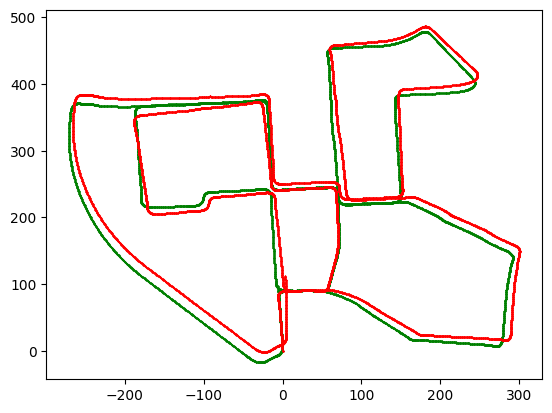

In [ ]:
fig, ax = plt.subplots(1)

ax.scatter(gt[:, 0], gt[:, 1], s=1, marker='x', color='g', linewidths=1)
ax.scatter(output[:, 0], output[:, 1], s=1, marker='x', color='r', linewidths=1)

plt.show()